In [46]:
import torch
import os, json
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
import torch.optim
from torch import Tensor
from torch.nn import CTCLoss
from torchvision.transforms import Compose
import string
from collections import OrderedDict
from tqdm import tqdm
import click
import editdistance
import glob
import pandas as pd

In [100]:
def text_collate(batch):
    img = list()
    seq = list()
    seq_len = list()
    for sample in batch:
        img.append(torch.from_numpy(sample["img"].transpose((2, 0, 1))).float())
        seq.extend(sample["seq"])
        seq_len.append(sample["seq_len"])
    img = torch.stack(img)
    seq = torch.Tensor(seq).int()
    seq_len = torch.Tensor(seq_len).int()
    batch = {"img": img, "seq": seq, "seq_len": seq_len}
    return batch

class ToTensor(object):
    def __call__(self, sample):
        sample["img"] = torch.from_numpy(sample["img"].transpose((2, 0, 1))).float()
        sample["seq"] = torch.Tensor(sample["seq"]).int()
        return sample


class Resize(object):
    def __init__(self, size=(320, 32)):
        self.size = size

    def __call__(self, sample):
        sample["img"] = cv2.resize(sample["img"], self.size)
        return sample


class Rotation(object):
    def __init__(self, angle=5, fill_value=0, p = 0.5):
        self.angle = angle
        self.fill_value = fill_value
        self.p = p

    def __call__(self, sample):
        if np.random.uniform(0.0, 1.0) < self.p or not sample["aug"]:
            return sample
        h,w,_ = sample["img"].shape
        #print(sample["img"].shape)
        ang_rot = np.random.uniform(self.angle) - self.angle/2          # 0-5之间随机采样并减2.5
        transform = cv2.getRotationMatrix2D((w/2, h/2), ang_rot, 1)     # 绕图像中心点旋转 ang_rot 角度
        sample["img"] = cv2.warpAffine(sample["img"], transform, (w,h), borderValue = self.fill_value)  # 对 img 进行仿射变换，变换方式为 transform，原图大小，边界填充值为0
        return sample


class Translation(object):
    def __init__(self, fill_value=0, p = 0.5):
        self.fill_value = fill_value
        self.p = p

    def __call__(self, sample):
        if np.random.uniform(0.0, 1.0) < self.p or not sample["aug"]:
            return sample
        h,w,_ = sample["img"].shape
        trans_range = [w / 10, h / 10]
        tr_x = trans_range[0]*np.random.uniform()-trans_range[0]/2
        tr_y = trans_range[1]*np.random.uniform()-trans_range[1]/2
        transform = np.float32([[1,0, tr_x], [0,1, tr_y]])
        sample["img"] = cv2.warpAffine(sample["img"], transform, (w,h), borderValue = self.fill_value)
        return sample

In [101]:
class TextDataset(Dataset):
    def __init__(self, data_path, data_label, transform=None):
        super().__init__()
        self.data_path = data_path
        self.data_label = data_label
        self.transform = transform

    def abc_len(self):
        return len('0123456789')

    def get_abc(self):
        return '0123456789'

    def set_mode(self, mode):
        self.mode = mode

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        text = self.data_label[idx]     # 读取标签中的文字

        img = cv2.imread(self.data_path[idx])
        seq = self.text_to_seq(text)    # 得到 text 所串成的 list
        sample = {"img": img, "seq": seq, "seq_len": len(seq), "aug": 1}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def text_to_seq(self, text):
        seq = []
        for c in text:
            seq.append(self.get_abc().find(str(c)) + 1)     # 循环找到 text 在0-9中的索引并形成列表
        return seq

In [102]:
class CRNN(nn.Module):
    def __init__(self,
                 abc='0123456789',
                 backend='resnet18',
                 rnn_hidden_size=256,
                 rnn_num_layers=1,
                 rnn_dropout=0,
                 seq_proj=[0, 0]):
        super(CRNN, self).__init__()

        self.abc = abc
        self.num_classes = len(self.abc)

        self.feature_extractor = getattr(models, backend)(weights=ResNet18_Weights.IMAGENET1K_V1)  # 得到 ResNet18
        self.cnn = nn.Sequential(
            self.feature_extractor.conv1,
            self.feature_extractor.bn1,
            self.feature_extractor.relu,
            self.feature_extractor.maxpool,
            self.feature_extractor.layer1,
            self.feature_extractor.layer2,
            self.feature_extractor.layer3,
            self.feature_extractor.layer4
        )

        self.fully_conv = seq_proj[0] == 0
        if not self.fully_conv:
            self.proj = nn.Conv2d(seq_proj[0], seq_proj[1], kernel_size=1)

        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        self.rnn = nn.GRU(self.get_block_size(self.cnn),
                          rnn_hidden_size, rnn_num_layers,
                          batch_first=False,
                          dropout=rnn_dropout, bidirectional=True)
        self.linear = nn.Linear(rnn_hidden_size * 2, self.num_classes + 1)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x, decode=False):
        hidden = self.init_hidden(x.size(0), next(self.parameters()).is_cuda)
        features = self.cnn(x)  # 得到特征图
        features = self.features_to_sequence(features)  # 得到特征序列
        seq, hidden = self.rnn(features, hidden)
        seq = self.linear(seq)
        if not self.training:
            seq = self.softmax(seq)
            if decode:
                seq = self.decode(seq)
        return seq

    def init_hidden(self, batch_size, gpu=False):
        h0 = Variable(torch.zeros( self.rnn_num_layers * 2,
                                   batch_size,
                                   self.rnn_hidden_size))
        if gpu:
            h0 = h0.cuda()
        return h0

    def features_to_sequence(self, features):
        features = features.mean(2)
        b, c, w = features.size()
        features = features.reshape(b, c, 1, w)
        b, c, h, w = features.size()
        #print(b, c, h, w)   # 20 512 1 7
        assert h == 1, "the height of out must be 1"
        if not self.fully_conv:
            features = features.permute(0, 3, 2, 1)  # 维度转换 b,w,h,c
            features = self.proj(features)
            features = features.permute(1, 0, 2, 3)
        else:
            features = features.permute(3, 0, 2, 1)  # w 为时间序列，b 为 bitch_size，c 为通道数
        features = features.squeeze(2)
        return features

    def get_block_size(self, layer):
        return layer[-1][-1].bn2.weight.size()[0]

    def pred_to_string(self, pred):
        seq = []
        for i in range(pred.shape[0]):
            label = np.argmax(pred[i])
            seq.append(label - 1)
        out = []
        for i in range(len(seq)):
            if len(out) == 0:
                if seq[i] != -1:
                    out.append(seq[i])
            else:
                if seq[i] != -1 and seq[i] != seq[i - 1]:
                    out.append(seq[i])
        out = ''.join(self.abc[i] for i in out)
        return out

    def decode(self, pred):
        pred = pred.permute(1, 0, 2).cpu().data.numpy()
        seq = []
        for i in range(pred.shape[0]):
            seq.append(self.pred_to_string(pred[i]))
        return seq

In [103]:
def load_weights(target, source_state):
    new_dict = OrderedDict()
    for k, v in target.state_dict().items():
        if k in source_state and v.size() == source_state[k].size():
            new_dict[k] = source_state[k]
        else:
            new_dict[k] = v
    target.load_state_dict(new_dict)


def load_model(abc, device, seq_proj=[0, 0], backend='resnet18', snapshot=None):
    net = CRNN(abc=abc, seq_proj=seq_proj, backend=backend)
    # net = nn.DataParallel(net)
    if snapshot is not None:
        load_weights(net, torch.load(snapshot))     # 加载权重
    #if cuda:
    net = net.to(device)
    return net

In [104]:
class StepLR(object):
    def __init__(self, optimizer, step_size=1000, max_iter=10000):
        self.optimizer = optimizer
        self.max_iter = max_iter
        self.step_size = step_size
        self.last_iter = -1
        self.base_lrs = list(map(lambda group: group['lr'], optimizer.param_groups))    # 得到初始学习率

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

    def step(self, last_iter=None):
        if last_iter is not None:
            self.last_iter = last_iter
        if self.last_iter + 1 == self.max_iter:
            self.last_iter = -1
        self.last_iter = (self.last_iter + 1) % self.max_iter
        for ids, param_group in enumerate(self.optimizer.param_groups):
            param_group['lr'] = self.base_lrs[ids] * 0.8 ** ( self.last_iter // self.step_size )    # 调整学习率

In [105]:
def test(net, data, abc, device, batch_size=50):
    data_loader = DataLoader(data, batch_size=batch_size, num_workers=4, shuffle=False, collate_fn=text_collate)

    count = 0
    tp = 0
    avg_ed = 0
    for sample in tqdm(data_loader):
        imgs = Variable(sample["img"])
        #if cuda:
        imgs = imgs.to(device)
        out = net(imgs, decode=True)
        gt = (sample["seq"].numpy() - 1).tolist()
        lens = sample["seq_len"].numpy().tolist()
        pos = 0
        key = ''
        for i in range(len(out)):
            gts = ''.join(abc[c] for c in gt[pos:pos+lens[i]])
            pos += lens[i]
            if gts == out[i]:
                tp += 1
            else:
                avg_ed += editdistance.eval(out[i], gts)
            count += 1

    acc = tp / count
    avg_ed = avg_ed / count
    return acc, avg_ed

In [92]:
data_tv = json.load(open('train.json'))
data_tv_label = [data_tv[x]['label'] for x in data_tv.keys()]   # 获得 json 中键为label的值，x为图片名，['label']为该图片下label值
data_tv_path = ['data/train/' + x for x in data_tv.keys()]   # 获得图像的路径，x为图片名

split_ratio = 0.9
train_label = data_tv_label[:int(len(data_tv) * split_ratio)]
train_path = data_tv_path[:int(len(data_tv) * split_ratio)]

val_label = data_tv_label[int(len(data_tv) * split_ratio):]
val_path = data_tv_path[int(len(data_tv) * split_ratio):]

In [93]:
def main(
        abc='0123456789',
        seq_proj="7x30",
        backend="resnet18",
        snapshot=None,
        input_size="200x100",   # x为分隔符
        base_lr=1e-3,
        step_size=1000,
        max_iter=15000,
        batch_size=20,
        output_dir='./',
        test_epoch=1,
        test_init=None,
        gpu='0'):
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    input_size = [int(x) for x in input_size.split('x')]    # [200,100]
    
    transform = Compose([
        Rotation(),     # 旋转
        Translation(),  # 平移
        # Scale(),
        Resize(size=(input_size[0], input_size[1]))
    ])

    data = TextDataset(train_path, train_label, transform=transform)
    data_val = TextDataset(val_path, val_label, transform=transform)

    seq_proj = [int(x) for x in seq_proj.split('x')]    # [7,30]
    net = load_model(data.get_abc(), device, seq_proj, backend, snapshot )           # 下载 model
    optimizer = torch.optim.Adam(net.parameters(), lr=base_lr, weight_decay=0.0001)  # 优化器
    lr_scheduler = StepLR(optimizer, step_size=step_size, max_iter=max_iter)         # 等间隔调整学习率
    loss_function = CTCLoss(zero_infinity=True)

    acc_best = 0
    epoch_count = 0

    val_acc = []
    train_loss = []

    while epoch_count < 100:
        if (test_epoch is not None and epoch_count != 0 and epoch_count % test_epoch == 0) or (
                test_init and epoch_count == 0):
            print("Test phase")
            data.set_mode("test")
            net = net.eval()
            acc, avg_ed = test(net, data_val, data.get_abc(), device, 50)
            val_acc.append(acc)

            net = net.train()
            data.set_mode("train")
            if acc > acc_best:
                if output_dir is not None:
                    torch.save(net.state_dict(),
                               os.path.join(output_dir, "crnn_" + backend + "_" + str(data.get_abc()) + "_best"))
                acc_best = acc
            print("acc: {}\tacc_best: {}; avg_ed: {}".format(acc, acc_best, avg_ed))

        data_loader = DataLoader(data, batch_size=batch_size, num_workers=1, shuffle=True, collate_fn=text_collate)     # text_collate将图片以及标签合为列表并以字典保存
        loss_mean = []
        iterator = tqdm(data_loader)
        iter_count = 0
        for sample in iterator:
            # for multi-gpu support
            #if sample["img"].size(0) % len(gpu.split(',')) != 0:
            #    continue
            if sample["img"].size(0) % batch_size != 0:
                continue
            optimizer.zero_grad()
            imgs = Variable(sample["img"])  # 将 tesnro 转为变量在 gpu 中加载
            labels = Variable(sample["seq"]).view(-1)
            label_lens = Variable(sample["seq_len"].int())

            imgs = imgs.to(device)
            preds = net(imgs).cpu()
            pred_lens = Variable(Tensor([preds.size(0)] * batch_size).int())

            # print(preds.shape, labels.shape)
            loss = loss_function(preds, labels, pred_lens, label_lens)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 10.0)
            loss_mean.append(loss.item())
            status = "epoch: {}; iter: {}; lr: {}; loss_mean: {}; loss: {}".format(epoch_count, lr_scheduler.last_iter,
                                                                                   lr_scheduler.get_lr(),
                                                                                   np.mean(loss_mean), loss.item())
            iterator.set_description(status)
            optimizer.step()
            lr_scheduler.step()
            iter_count += 1
        if output_dir is not None:
            torch.save(net.state_dict(),
                       os.path.join(output_dir, "crnn_" + backend + "_" + str(data.get_abc()) + "_last"))
        epoch_count += 1
        train_loss.append(np.mean(loss_mean))

    return val_acc, train_loss

In [55]:
val_acc, train_loss = main()

epoch: 0; iter: 1501; lr: 0.0008; loss_mean: 1.8297712833224655; loss: 1.3795256614685059: 100%|██████████| 1504/1504 [02:13<00:00, 11.23it/s] 


Test phase


100%|██████████| 67/67 [00:04<00:00, 13.72it/s]


acc: 0.5366656689613888	acc_best: 0.5366656689613888; avg_ed: 0.70487877880874


epoch: 1; iter: 3004; lr: 0.0005120000000000001; loss_mean: 0.9465995087949478; loss: 0.6163305044174194: 100%|██████████| 1504/1504 [02:13<00:00, 11.30it/s] 


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.30it/s]


acc: 0.6459143968871596	acc_best: 0.6459143968871596; avg_ed: 0.5052379527087698


epoch: 2; iter: 4507; lr: 0.0004096000000000001; loss_mean: 0.704914715116892; loss: 0.6932080984115601: 100%|██████████| 1504/1504 [02:13<00:00, 11.23it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.94it/s]


acc: 0.6884166417240347	acc_best: 0.6884166417240347; avg_ed: 0.42382520203531876


epoch: 3; iter: 6010; lr: 0.0002621440000000001; loss_mean: 0.5712652621891149; loss: 1.124281644821167: 100%|██████████| 1504/1504 [02:13<00:00, 11.23it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.39it/s]


acc: 0.7303202633941933	acc_best: 0.7303202633941933; avg_ed: 0.36276563903023046


epoch: 4; iter: 7513; lr: 0.0002097152000000001; loss_mean: 0.46320448124890307; loss: 0.6330288052558899: 100%|██████████| 1504/1504 [02:10<00:00, 11.49it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.87it/s]


acc: 0.7482789583956899	acc_best: 0.7482789583956899; avg_ed: 0.3412152050284346


epoch: 5; iter: 9016; lr: 0.00013421772800000008; loss_mean: 0.3864911181059234; loss: 0.42574644088745117: 100%|██████████| 1504/1504 [02:20<00:00, 10.70it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 13.64it/s]


acc: 0.7563603711463633	acc_best: 0.7563603711463633; avg_ed: 0.33193654594432803


epoch: 6; iter: 10519; lr: 0.00010737418240000006; loss_mean: 0.319530441893745; loss: 0.34874099493026733: 100%|██████████| 1504/1504 [02:24<00:00, 10.41it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.04it/s]


acc: 0.7719245734809937	acc_best: 0.7719245734809937; avg_ed: 0.3002095181083508


epoch: 7; iter: 12022; lr: 6.871947673600005e-05; loss_mean: 0.2645421064038902; loss: 0.20595435798168182: 100%|██████████| 1504/1504 [02:23<00:00, 10.45it/s]   


Test phase


100%|██████████| 67/67 [00:05<00:00, 12.96it/s]


acc: 0.7838970368153247	acc_best: 0.7838970368153247; avg_ed: 0.28195151152349596


epoch: 8; iter: 13525; lr: 5.497558138880004e-05; loss_mean: 0.22608350299104196; loss: 0.24564361572265625: 100%|██████████| 1504/1504 [02:15<00:00, 11.13it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.31it/s]


acc: 0.7865908410655492	acc_best: 0.7865908410655492; avg_ed: 0.2840466926070039


epoch: 9; iter: 28; lr: 0.001; loss_mean: 0.21908683837241946; loss: 4.9878129959106445: 100%|██████████| 1504/1504 [02:33<00:00,  9.78it/s]                       


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.80it/s]


acc: 0.6890152648907513	acc_best: 0.7865908410655492; avg_ed: 0.4163424124513619


epoch: 10; iter: 1531; lr: 0.0008; loss_mean: 0.6512460417297613; loss: 0.49145108461380005: 100%|██████████| 1504/1504 [02:15<00:00, 11.11it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.51it/s]


acc: 0.6869200838072433	acc_best: 0.7865908410655492; avg_ed: 0.4405866507033822


epoch: 11; iter: 3034; lr: 0.0005120000000000001; loss_mean: 0.5247821833254275; loss: 0.6843569874763489: 100%|██████████| 1504/1504 [02:13<00:00, 11.25it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.50it/s]


acc: 0.7249326548937444	acc_best: 0.7865908410655492; avg_ed: 0.37204429811433704


epoch: 12; iter: 4537; lr: 0.0004096000000000001; loss_mean: 0.4236626298593125; loss: 0.5854705572128296: 100%|██████████| 1504/1504 [02:16<00:00, 11.05it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.29it/s]


acc: 0.749476204729123	acc_best: 0.7865908410655492; avg_ed: 0.328644118527387


epoch: 13; iter: 6040; lr: 0.0002621440000000001; loss_mean: 0.3441564115945526; loss: 0.265826940536499: 100%|██████████| 1504/1504 [02:39<00:00,  9.43it/s]     


Test phase


100%|██████████| 67/67 [00:06<00:00, 10.27it/s]


acc: 0.7521700089793475	acc_best: 0.7865908410655492; avg_ed: 0.33163723436096976


epoch: 14; iter: 7543; lr: 0.0002097152000000001; loss_mean: 0.27538720304589454; loss: 0.259318083524704: 100%|██████████| 1504/1504 [03:00<00:00,  8.34it/s]    


Test phase


100%|██████████| 67/67 [00:05<00:00, 11.31it/s]


acc: 0.7865908410655492	acc_best: 0.7865908410655492; avg_ed: 0.27596527985633046


epoch: 15; iter: 9046; lr: 0.00013421772800000008; loss_mean: 0.2226841982672253; loss: 0.1267290711402893: 100%|██████████| 1504/1504 [03:14<00:00,  7.75it/s]    


Test phase


100%|██████████| 67/67 [00:05<00:00, 12.99it/s]


acc: 0.7934750074827895	acc_best: 0.7934750074827895; avg_ed: 0.2654893744387908


epoch: 16; iter: 10549; lr: 0.00010737418240000006; loss_mean: 0.1807836481867663; loss: 0.12280131876468658: 100%|██████████| 1504/1504 [02:22<00:00, 10.57it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.91it/s]


acc: 0.792876384316073	acc_best: 0.7934750074827895; avg_ed: 0.2687818018557318


epoch: 17; iter: 12052; lr: 6.871947673600005e-05; loss_mean: 0.1509342402473361; loss: 0.19757872819900513: 100%|██████████| 1504/1504 [02:12<00:00, 11.33it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.25it/s]


acc: 0.8015564202334631	acc_best: 0.8015564202334631; avg_ed: 0.2595031427716253


epoch: 18; iter: 13555; lr: 5.497558138880004e-05; loss_mean: 0.12770779883266212; loss: 0.06761367619037628: 100%|██████████| 1504/1504 [02:12<00:00, 11.32it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.59it/s]


acc: 0.8045495360670458	acc_best: 0.8045495360670458; avg_ed: 0.25591140377132593


epoch: 19; iter: 58; lr: 0.001; loss_mean: 0.11033144060538042; loss: -1.2170467376708984: 100%|██████████| 1504/1504 [02:13<00:00, 11.24it/s]                      


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.57it/s]


acc: 0.7620472912301706	acc_best: 0.8045495360670458; avg_ed: 0.31068542352589046


epoch: 20; iter: 1561; lr: 0.0008; loss_mean: 0.5575696067162371; loss: 1.0278279781341553: 100%|██████████| 1504/1504 [02:15<00:00, 11.10it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.02it/s]


acc: 0.7225381622268782	acc_best: 0.8045495360670458; avg_ed: 0.3645615085303801


epoch: 21; iter: 3064; lr: 0.0005120000000000001; loss_mean: 0.4254218228443272; loss: 0.3914565145969391: 100%|██████████| 1504/1504 [02:13<00:00, 11.29it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.23it/s]


acc: 0.7503741394791978	acc_best: 0.8045495360670458; avg_ed: 0.3277461837773122


epoch: 22; iter: 4567; lr: 0.0004096000000000001; loss_mean: 0.3308856407784817; loss: 0.24383068084716797: 100%|██████████| 1504/1504 [02:12<00:00, 11.33it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.72it/s]


acc: 0.7701287039808441	acc_best: 0.8045495360670458; avg_ed: 0.30170607602514216


epoch: 23; iter: 6070; lr: 0.0002621440000000001; loss_mean: 0.2656812265471991; loss: 0.036480821669101715: 100%|██████████| 1504/1504 [02:13<00:00, 11.27it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.81it/s]


acc: 0.7889853337324154	acc_best: 0.8045495360670458; avg_ed: 0.2714756061059563


epoch: 24; iter: 7573; lr: 0.0002097152000000001; loss_mean: 0.20832562442084404; loss: 0.3024377226829529: 100%|██████████| 1504/1504 [02:13<00:00, 11.25it/s]     


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.45it/s]


acc: 0.7877880873989823	acc_best: 0.8045495360670458; avg_ed: 0.27716252618976356


epoch: 25; iter: 9076; lr: 0.00013421772800000008; loss_mean: 0.16762394147519272; loss: 0.15535496175289154: 100%|██████████| 1504/1504 [02:13<00:00, 11.24it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.47it/s]


acc: 0.798263992816522	acc_best: 0.8045495360670458; avg_ed: 0.2607003891050584


epoch: 26; iter: 10579; lr: 0.00010737418240000006; loss_mean: 0.1368277898603658; loss: 0.18458494544029236: 100%|██████████| 1504/1504 [02:13<00:00, 11.28it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.64it/s]


acc: 0.7967674348997306	acc_best: 0.8045495360670458; avg_ed: 0.25860520802155046


epoch: 27; iter: 12082; lr: 6.871947673600005e-05; loss_mean: 0.11077084143426659; loss: 0.12437357753515244: 100%|██████████| 1504/1504 [02:12<00:00, 11.31it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.42it/s]


acc: 0.8135288835677941	acc_best: 0.8135288835677941; avg_ed: 0.24004788985333733


epoch: 28; iter: 13585; lr: 5.497558138880004e-05; loss_mean: 0.09737619309868406; loss: -0.042076416313648224: 100%|██████████| 1504/1504 [02:13<00:00, 11.29it/s] 


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.22it/s]


acc: 0.8081412750673451	acc_best: 0.8135288835677941; avg_ed: 0.2427416941035618


epoch: 29; iter: 88; lr: 0.001; loss_mean: 0.10816844387631298; loss: -1.2236576080322266: 100%|██████████| 1504/1504 [02:13<00:00, 11.28it/s]                       


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.14it/s]


acc: 0.7252319664771026	acc_best: 0.8135288835677941; avg_ed: 0.36067045794672253


epoch: 30; iter: 1591; lr: 0.0008; loss_mean: 0.5115175259808302; loss: 0.6174147129058838: 100%|██████████| 1504/1504 [02:14<00:00, 11.18it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.85it/s]


acc: 0.6923076923076923	acc_best: 0.8135288835677941; avg_ed: 0.41005686920083806


epoch: 31; iter: 3094; lr: 0.0005120000000000001; loss_mean: 0.3735892157243374; loss: 0.4548301696777344: 100%|██████████| 1504/1504 [02:13<00:00, 11.26it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.09it/s]


acc: 0.7602514217300209	acc_best: 0.8135288835677941; avg_ed: 0.3238551331936546


epoch: 32; iter: 4597; lr: 0.0004096000000000001; loss_mean: 0.28580248486839493; loss: 0.11182292550802231: 100%|██████████| 1504/1504 [02:13<00:00, 11.28it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.13it/s]


acc: 0.7859922178988327	acc_best: 0.8135288835677941; avg_ed: 0.2777611493564801


epoch: 33; iter: 6100; lr: 0.0002621440000000001; loss_mean: 0.2228504177212346; loss: 0.001878455514088273: 100%|██████████| 1504/1504 [02:16<00:00, 11.04it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.74it/s]


acc: 0.7955701885662975	acc_best: 0.8135288835677941; avg_ed: 0.2642921281053577


epoch: 34; iter: 7603; lr: 0.0002097152000000001; loss_mean: 0.17276569918343793; loss: 0.1735660284757614: 100%|██████████| 1504/1504 [02:13<00:00, 11.23it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.05it/s]


acc: 0.8039509129003293	acc_best: 0.8135288835677941; avg_ed: 0.2565100269380425


epoch: 35; iter: 9106; lr: 0.00013421772800000008; loss_mean: 0.14161506117746317; loss: 0.5177218914031982: 100%|██████████| 1504/1504 [02:14<00:00, 11.21it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.33it/s]


acc: 0.8006584854833882	acc_best: 0.8135288835677941; avg_ed: 0.2577072732714756


epoch: 36; iter: 10609; lr: 0.00010737418240000006; loss_mean: 0.1113221855556914; loss: 0.0717456191778183: 100%|██████████| 1504/1504 [02:14<00:00, 11.19it/s]     


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.70it/s]


acc: 0.8129302604010775	acc_best: 0.8135288835677941; avg_ed: 0.24064651302005388


epoch: 37; iter: 12112; lr: 6.871947673600005e-05; loss_mean: 0.0960756008809001; loss: 0.07144105434417725: 100%|██████████| 1504/1504 [02:14<00:00, 11.19it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.61it/s]


acc: 0.7955701885662975	acc_best: 0.8135288835677941; avg_ed: 0.2580065848548339


epoch: 38; iter: 13615; lr: 5.497558138880004e-05; loss_mean: 0.08324235898705876; loss: 0.349078893661499: 100%|██████████| 1504/1504 [02:12<00:00, 11.31it/s]     


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.79it/s]


acc: 0.8057467824004789	acc_best: 0.8135288835677941; avg_ed: 0.24723136785393596


epoch: 39; iter: 118; lr: 0.001; loss_mean: 0.1075748868898952; loss: 0.7417362928390503: 100%|██████████| 1504/1504 [02:13<00:00, 11.25it/s]                       


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.75it/s]


acc: 0.665968272972164	acc_best: 0.8135288835677941; avg_ed: 0.4624363962885364


epoch: 40; iter: 1621; lr: 0.0008; loss_mean: 0.47205762296273107; loss: 0.4692329466342926: 100%|██████████| 1504/1504 [02:14<00:00, 11.21it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.19it/s]


acc: 0.7288237054774019	acc_best: 0.8135288835677941; avg_ed: 0.3597725231966477


epoch: 41; iter: 3124; lr: 0.0005120000000000001; loss_mean: 0.33987360506802644; loss: 0.19776573777198792: 100%|██████████| 1504/1504 [02:14<00:00, 11.22it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.08it/s]


acc: 0.7838970368153247	acc_best: 0.8135288835677941; avg_ed: 0.28225082310685423


epoch: 42; iter: 4627; lr: 0.0004096000000000001; loss_mean: 0.25351325347951437; loss: 0.06819503009319305: 100%|██████████| 1504/1504 [02:20<00:00, 10.72it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.37it/s]


acc: 0.7719245734809937	acc_best: 0.8135288835677941; avg_ed: 0.29242741694103563


epoch: 43; iter: 6130; lr: 0.0002621440000000001; loss_mean: 0.20017395826547937; loss: 0.23258137702941895: 100%|██████████| 1504/1504 [02:18<00:00, 10.87it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.74it/s]


acc: 0.7940736306495061	acc_best: 0.8135288835677941; avg_ed: 0.2666866207722239


epoch: 44; iter: 7633; lr: 0.0002097152000000001; loss_mean: 0.15370779934389223; loss: 0.06833238899707794: 100%|██████████| 1504/1504 [02:12<00:00, 11.39it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.95it/s]


acc: 0.8078419634839868	acc_best: 0.8135288835677941; avg_ed: 0.24723136785393596


epoch: 45; iter: 9136; lr: 0.00013421772800000008; loss_mean: 0.12336018426180737; loss: 0.22567816078662872: 100%|██████████| 1504/1504 [02:13<00:00, 11.27it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.85it/s]


acc: 0.810236456150853	acc_best: 0.8135288835677941; avg_ed: 0.24483687518706973


epoch: 46; iter: 10639; lr: 0.00010737418240000006; loss_mean: 0.100488337768779; loss: 0.013136861845850945: 100%|██████████| 1504/1504 [02:15<00:00, 11.12it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.30it/s]


acc: 0.8114337024842861	acc_best: 0.8135288835677941; avg_ed: 0.2391499551032625


epoch: 47; iter: 12142; lr: 6.871947673600005e-05; loss_mean: 0.08595641765947483; loss: 0.05848131701350212: 100%|██████████| 1504/1504 [02:15<00:00, 11.13it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.02it/s]


acc: 0.8141275067345106	acc_best: 0.8141275067345106; avg_ed: 0.24244238252020353


epoch: 48; iter: 13645; lr: 5.497558138880004e-05; loss_mean: 0.07248186515076155; loss: 0.06804175674915314: 100%|██████████| 1504/1504 [02:13<00:00, 11.26it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.41it/s]


acc: 0.8138281951511523	acc_best: 0.8141275067345106; avg_ed: 0.23974857826997906


epoch: 49; iter: 148; lr: 0.001; loss_mean: 0.09971394405897158; loss: 0.9774181246757507: 100%|██████████| 1504/1504 [02:13<00:00, 11.26it/s]                      


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.93it/s]


acc: 0.6114935648009578	acc_best: 0.8141275067345106; avg_ed: 0.521700089793475


epoch: 50; iter: 1651; lr: 0.0008; loss_mean: 0.4453413077082184; loss: 0.0876411572098732: 100%|██████████| 1504/1504 [02:14<00:00, 11.22it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.92it/s]


acc: 0.7398982340616582	acc_best: 0.8141275067345106; avg_ed: 0.3448069440287339


epoch: 51; iter: 3154; lr: 0.0005120000000000001; loss_mean: 0.3081163633394418; loss: 0.6992672681808472: 100%|██████████| 1504/1504 [02:13<00:00, 11.27it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.15it/s]


acc: 0.7710266387309189	acc_best: 0.8141275067345106; avg_ed: 0.29571984435797666


epoch: 52; iter: 4657; lr: 0.0004096000000000001; loss_mean: 0.23174339185454484; loss: -0.0063462033867836: 100%|██████████| 1504/1504 [02:14<00:00, 11.19it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.73it/s]


acc: 0.7770128703980844	acc_best: 0.8141275067345106; avg_ed: 0.2903322358575277


epoch: 53; iter: 6160; lr: 0.0002621440000000001; loss_mean: 0.18090976339275608; loss: 0.07733731716871262: 100%|██████████| 1504/1504 [02:15<00:00, 11.11it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.93it/s]


acc: 0.7994612391499551	acc_best: 0.8141275067345106; avg_ed: 0.25980245435498356


epoch: 54; iter: 7663; lr: 0.0002097152000000001; loss_mean: 0.14160653289577274; loss: 0.05779040977358818: 100%|██████████| 1504/1504 [02:13<00:00, 11.25it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.08it/s]


acc: 0.796168811733014	acc_best: 0.8141275067345106; avg_ed: 0.2553127806046094


epoch: 55; iter: 9166; lr: 0.00013421772800000008; loss_mean: 0.11305425110055047; loss: 0.11198625713586807: 100%|██████████| 1504/1504 [02:22<00:00, 10.58it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.57it/s]


acc: 0.8066447171505537	acc_best: 0.8141275067345106; avg_ed: 0.24723136785393596


epoch: 56; iter: 10669; lr: 0.00010737418240000006; loss_mean: 0.09071019631322953; loss: 0.14522960782051086: 100%|██████████| 1504/1504 [02:28<00:00, 10.11it/s]    


Test phase


100%|██████████| 67/67 [00:05<00:00, 12.38it/s]


acc: 0.8117330140676444	acc_best: 0.8141275067345106; avg_ed: 0.2403472014366956


epoch: 57; iter: 12172; lr: 6.871947673600005e-05; loss_mean: 0.07883747089462893; loss: 0.016846265643835068: 100%|██████████| 1504/1504 [02:28<00:00, 10.16it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.02it/s]


acc: 0.8171206225680934	acc_best: 0.8171206225680934; avg_ed: 0.2376533971864711


epoch: 58; iter: 13675; lr: 5.497558138880004e-05; loss_mean: 0.06933087514524339; loss: 0.11815376579761505: 100%|██████████| 1504/1504 [02:15<00:00, 11.14it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.19it/s]


acc: 0.8159233762346603	acc_best: 0.8171206225680934; avg_ed: 0.2352589045196049


epoch: 59; iter: 178; lr: 0.001; loss_mean: 0.11244103495014585; loss: 0.44425076246261597: 100%|██████████| 1504/1504 [02:18<00:00, 10.83it/s]                      


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.82it/s]


acc: 0.6997904818916492	acc_best: 0.8171206225680934; avg_ed: 0.40526788386710566


epoch: 60; iter: 1681; lr: 0.0008; loss_mean: 0.4168306272181032; loss: 0.3564648926258087: 100%|██████████| 1504/1504 [02:15<00:00, 11.09it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.16it/s]


acc: 0.7599521101466626	acc_best: 0.8171206225680934; avg_ed: 0.3277461837773122


epoch: 61; iter: 3184; lr: 0.0005120000000000001; loss_mean: 0.290169406830057; loss: 0.28071489930152893: 100%|██████████| 1504/1504 [02:15<00:00, 11.13it/s]     


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.93it/s]


acc: 0.7877880873989823	acc_best: 0.8171206225680934; avg_ed: 0.27297216402274765


epoch: 62; iter: 4687; lr: 0.0004096000000000001; loss_mean: 0.2183324702547867; loss: 0.17109262943267822: 100%|██████████| 1504/1504 [02:15<00:00, 11.08it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 13.64it/s]


acc: 0.7976653696498055	acc_best: 0.8171206225680934; avg_ed: 0.26339419335528286


epoch: 63; iter: 6190; lr: 0.0002621440000000001; loss_mean: 0.16539294291451986; loss: 0.3640604317188263: 100%|██████████| 1504/1504 [02:20<00:00, 10.71it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.30it/s]


acc: 0.8009577970667465	acc_best: 0.8171206225680934; avg_ed: 0.2550134690212511


epoch: 64; iter: 7693; lr: 0.0002097152000000001; loss_mean: 0.12626616360884038; loss: 0.025500351563096046: 100%|██████████| 1504/1504 [02:24<00:00, 10.42it/s]  


Test phase


100%|██████████| 67/67 [00:05<00:00, 13.15it/s]


acc: 0.8129302604010775	acc_best: 0.8171206225680934; avg_ed: 0.24543549835378628


epoch: 65; iter: 9196; lr: 0.00013421772800000008; loss_mean: 0.10431662680784648; loss: 0.07718348503112793: 100%|██████████| 1504/1504 [02:15<00:00, 11.09it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.21it/s]


acc: 0.8117330140676444	acc_best: 0.8171206225680934; avg_ed: 0.24543549835378628


epoch: 66; iter: 10699; lr: 0.00010737418240000006; loss_mean: 0.08690927488288559; loss: 0.051720209419727325: 100%|██████████| 1504/1504 [02:16<00:00, 11.03it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.84it/s]


acc: 0.8093385214007782	acc_best: 0.8171206225680934; avg_ed: 0.24244238252020353


epoch: 67; iter: 12202; lr: 6.871947673600005e-05; loss_mean: 0.07219271876271456; loss: 0.025684043765068054: 100%|██████████| 1504/1504 [02:07<00:00, 11.75it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 16.15it/s]


acc: 0.8219096079018258	acc_best: 0.8219096079018258; avg_ed: 0.22807542651900628


epoch: 68; iter: 13705; lr: 5.497558138880004e-05; loss_mean: 0.06655931985055841; loss: 0.10534314066171646: 100%|██████████| 1504/1504 [02:07<00:00, 11.77it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 16.47it/s]


acc: 0.8120323256510027	acc_best: 0.8219096079018258; avg_ed: 0.24214307093684526


epoch: 69; iter: 208; lr: 0.001; loss_mean: 0.11021506194112773; loss: 0.3545861840248108: 100%|██████████| 1504/1504 [02:06<00:00, 11.93it/s]                        


Test phase


100%|██████████| 67/67 [00:04<00:00, 16.12it/s]


acc: 0.6997904818916492	acc_best: 0.8219096079018258; avg_ed: 0.40796168811733013


epoch: 70; iter: 1711; lr: 0.0008; loss_mean: 0.40430040813885126; loss: 0.7279609441757202: 100%|██████████| 1504/1504 [02:12<00:00, 11.31it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.35it/s]


acc: 0.7770128703980844	acc_best: 0.8219096079018258; avg_ed: 0.30050882969170906


epoch: 71; iter: 3214; lr: 0.0005120000000000001; loss_mean: 0.27508586031713256; loss: -0.10371887683868408: 100%|██████████| 1504/1504 [02:19<00:00, 10.81it/s] 


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.34it/s]


acc: 0.7758156240646513	acc_best: 0.8219096079018258; avg_ed: 0.29332535169111046


epoch: 72; iter: 4717; lr: 0.0004096000000000001; loss_mean: 0.2040343042022731; loss: 0.07440981268882751: 100%|██████████| 1504/1504 [02:21<00:00, 10.60it/s]    


Test phase


100%|██████████| 67/67 [00:05<00:00, 12.87it/s]


acc: 0.7850942831487578	acc_best: 0.8219096079018258; avg_ed: 0.2840466926070039


epoch: 73; iter: 6220; lr: 0.0002621440000000001; loss_mean: 0.15307340453354382; loss: 0.11956016719341278: 100%|██████████| 1504/1504 [02:19<00:00, 10.76it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.07it/s]


acc: 0.8063454055671955	acc_best: 0.8219096079018258; avg_ed: 0.2514217300209518


epoch: 74; iter: 7723; lr: 0.0002097152000000001; loss_mean: 0.12094143968702244; loss: 0.0470266118645668: 100%|██████████| 1504/1504 [02:18<00:00, 10.83it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.60it/s]


acc: 0.8132295719844358	acc_best: 0.8219096079018258; avg_ed: 0.24363962885363663


epoch: 75; iter: 9226; lr: 0.00013421772800000008; loss_mean: 0.09612516737813318; loss: 0.019511563703417778: 100%|██████████| 1504/1504 [02:17<00:00, 10.95it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.43it/s]


acc: 0.810236456150853	acc_best: 0.8219096079018258; avg_ed: 0.24543549835378628


epoch: 76; iter: 10729; lr: 0.00010737418240000006; loss_mean: 0.08153421517767835; loss: 0.18024763464927673: 100%|██████████| 1504/1504 [02:06<00:00, 11.87it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 16.47it/s]


acc: 0.8144268183178689	acc_best: 0.8219096079018258; avg_ed: 0.23885064351990423


epoch: 77; iter: 12232; lr: 6.871947673600005e-05; loss_mean: 0.07294987937561319; loss: 0.0033436515368521214: 100%|██████████| 1504/1504 [02:11<00:00, 11.42it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.33it/s]


acc: 0.8087398982340617	acc_best: 0.8219096079018258; avg_ed: 0.2415444477701287


epoch: 78; iter: 13735; lr: 5.497558138880004e-05; loss_mean: 0.06105927242109972; loss: 0.008584670722484589: 100%|██████████| 1504/1504 [02:07<00:00, 11.77it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 16.26it/s]


acc: 0.8171206225680934	acc_best: 0.8219096079018258; avg_ed: 0.2340616581861718


epoch: 79; iter: 238; lr: 0.001; loss_mean: 0.10917856296690663; loss: 0.47448307275772095: 100%|██████████| 1504/1504 [02:06<00:00, 11.87it/s]                      


Test phase


100%|██████████| 67/67 [00:04<00:00, 16.15it/s]


acc: 0.7024842861418736	acc_best: 0.8219096079018258; avg_ed: 0.394791978449566


epoch: 80; iter: 1741; lr: 0.0008; loss_mean: 0.3768842848768155; loss: 0.6857190728187561: 100%|██████████| 1504/1504 [02:07<00:00, 11.78it/s]     


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.88it/s]


acc: 0.7602514217300209	acc_best: 0.8219096079018258; avg_ed: 0.3172702783597725


epoch: 81; iter: 3244; lr: 0.0005120000000000001; loss_mean: 0.2639466470664495; loss: 0.09587366878986359: 100%|██████████| 1504/1504 [02:09<00:00, 11.61it/s]    


Test phase


100%|██████████| 67/67 [00:05<00:00, 12.87it/s]


acc: 0.7806046093983837	acc_best: 0.8219096079018258; avg_ed: 0.2813528883567794


epoch: 82; iter: 4747; lr: 0.0004096000000000001; loss_mean: 0.1965056534978395; loss: 0.004230146296322346: 100%|██████████| 1504/1504 [02:32<00:00,  9.89it/s]  


Test phase


100%|██████████| 67/67 [00:05<00:00, 11.87it/s]


acc: 0.7889853337324154	acc_best: 0.8219096079018258; avg_ed: 0.27207422927267283


epoch: 83; iter: 6250; lr: 0.0002621440000000001; loss_mean: 0.150268195749487; loss: 0.10852370411157608: 100%|██████████| 1504/1504 [02:47<00:00,  8.96it/s]     


Test phase


100%|██████████| 67/67 [00:05<00:00, 11.42it/s]


acc: 0.7943729422328644	acc_best: 0.8219096079018258; avg_ed: 0.267883867105657


epoch: 84; iter: 7753; lr: 0.0002097152000000001; loss_mean: 0.11585866250917616; loss: 0.04689569026231766: 100%|██████████| 1504/1504 [02:24<00:00, 10.38it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.77it/s]


acc: 0.7991619275665969	acc_best: 0.8219096079018258; avg_ed: 0.25591140377132593


epoch: 85; iter: 9256; lr: 0.00013421772800000008; loss_mean: 0.09187784875839697; loss: 0.056469060480594635: 100%|██████████| 1504/1504 [02:16<00:00, 11.04it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 13.95it/s]


acc: 0.8126309488177192	acc_best: 0.8219096079018258; avg_ed: 0.24064651302005388


epoch: 86; iter: 10759; lr: 0.00010737418240000006; loss_mean: 0.07693500520972806; loss: 0.04469948261976242: 100%|██████████| 1504/1504 [02:23<00:00, 10.51it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 13.89it/s]


acc: 0.8132295719844358	acc_best: 0.8219096079018258; avg_ed: 0.2415444477701287


epoch: 87; iter: 12262; lr: 6.871947673600005e-05; loss_mean: 0.06400799775633202; loss: 0.06066235899925232: 100%|██████████| 1504/1504 [02:20<00:00, 10.72it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 13.52it/s]


acc: 0.8132295719844358	acc_best: 0.8219096079018258; avg_ed: 0.24573480993714455


epoch: 88; iter: 13765; lr: 5.497558138880004e-05; loss_mean: 0.05985363471667677; loss: 0.0921470895409584: 100%|██████████| 1504/1504 [02:22<00:00, 10.59it/s]     


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.51it/s]


acc: 0.8132295719844358	acc_best: 0.8219096079018258; avg_ed: 0.23855133193654596


epoch: 89; iter: 268; lr: 0.001; loss_mean: 0.11400067646750354; loss: 1.0240554809570312: 100%|██████████| 1504/1504 [02:21<00:00, 10.63it/s]                       


Test phase


100%|██████████| 67/67 [00:04<00:00, 13.59it/s]


acc: 0.6545944328045495	acc_best: 0.8219096079018258; avg_ed: 0.469619874289135


epoch: 90; iter: 1771; lr: 0.0008; loss_mean: 0.3690892427300967; loss: 0.5539266467094421: 100%|██████████| 1504/1504 [02:24<00:00, 10.42it/s]     


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.70it/s]


acc: 0.7572583058964382	acc_best: 0.8219096079018258; avg_ed: 0.3136785393594732


epoch: 91; iter: 3274; lr: 0.0005120000000000001; loss_mean: 0.25189823185646965; loss: 0.23053745925426483: 100%|██████████| 1504/1504 [02:15<00:00, 11.10it/s]  


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.70it/s]


acc: 0.787488775815624	acc_best: 0.8219096079018258; avg_ed: 0.27506734510625563


epoch: 92; iter: 4777; lr: 0.0004096000000000001; loss_mean: 0.18616581459112544; loss: 0.259477436542511: 100%|██████████| 1504/1504 [02:12<00:00, 11.39it/s]     


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.45it/s]


acc: 0.7922777611493564	acc_best: 0.8219096079018258; avg_ed: 0.2687818018557318


epoch: 93; iter: 6280; lr: 0.0002621440000000001; loss_mean: 0.14500528640750532; loss: 0.08786822110414505: 100%|██████████| 1504/1504 [02:11<00:00, 11.48it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 15.82it/s]


acc: 0.798263992816522	acc_best: 0.8219096079018258; avg_ed: 0.2604010775217001


epoch: 94; iter: 7783; lr: 0.0002097152000000001; loss_mean: 0.11192950968859221; loss: 0.11625248193740845: 100%|██████████| 1504/1504 [02:16<00:00, 11.01it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.87it/s]


acc: 0.80903920981742	acc_best: 0.8219096079018258; avg_ed: 0.2391499551032625


epoch: 95; iter: 9286; lr: 0.00013421772800000008; loss_mean: 0.08888240748873083; loss: 0.09962496161460876: 100%|██████████| 1504/1504 [02:11<00:00, 11.44it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 16.52it/s]


acc: 0.8114337024842861	acc_best: 0.8219096079018258; avg_ed: 0.24304100568692008


epoch: 96; iter: 10789; lr: 0.00010737418240000006; loss_mean: 0.07170269240778022; loss: 0.03787369281053543: 100%|██████████| 1504/1504 [02:20<00:00, 10.69it/s]    


Test phase


100%|██████████| 67/67 [00:04<00:00, 13.83it/s]


acc: 0.8171206225680934	acc_best: 0.8219096079018258; avg_ed: 0.23585752768632146


epoch: 97; iter: 12292; lr: 6.871947673600005e-05; loss_mean: 0.06323588029265177; loss: 0.08621831983327866: 100%|██████████| 1504/1504 [02:28<00:00, 10.15it/s]    


Test phase


100%|██████████| 67/67 [00:05<00:00, 11.97it/s]


acc: 0.8198144268183178	acc_best: 0.8219096079018258; avg_ed: 0.23316372343609698


epoch: 98; iter: 13795; lr: 5.497558138880004e-05; loss_mean: 0.05506083731805432; loss: -0.03501560911536217: 100%|██████████| 1504/1504 [02:23<00:00, 10.46it/s]   


Test phase


100%|██████████| 67/67 [00:04<00:00, 14.73it/s]


acc: 0.812331637234361	acc_best: 0.8219096079018258; avg_ed: 0.23974857826997906


epoch: 99; iter: 298; lr: 0.001; loss_mean: 0.1270876573780225; loss: 0.2553790211677551: 100%|██████████| 1504/1504 [02:14<00:00, 11.17it/s]                         


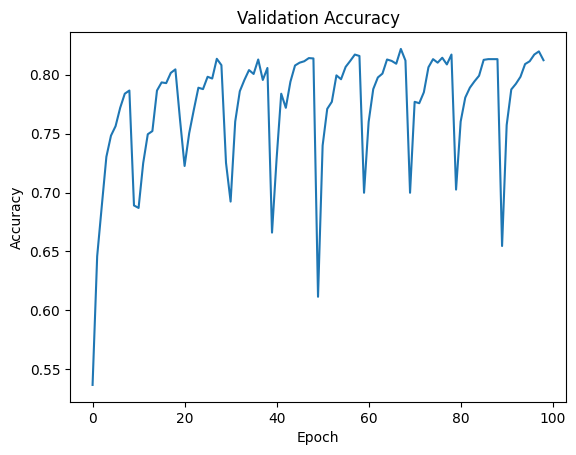

In [59]:
import matplotlib.pyplot as plt
import numpy as np


# 创建折线图
plt.plot(val_acc)

# 添加标题和标签
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# 显示图形
plt.show()

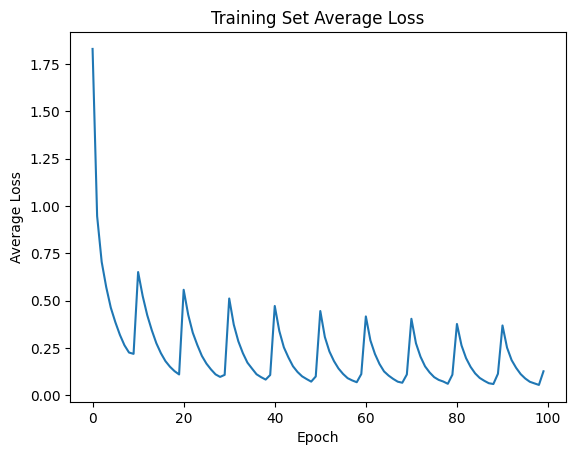

In [57]:
import matplotlib.pyplot as plt
import numpy as np


# 创建折线图
plt.plot(train_loss)

# 添加标题和标签
plt.title("Training Set Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

# 显示图形
plt.show()

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_labels_path = 'data/test_labels'
test_base_path = 'data/test/'

test_path = []

for i in range(len(os.listdir(test_labels_path))):
    test_path.append(test_base_path + str(i+1) + '.png')
  
print(test_path[:5])

test_label = [[1]] * len(test_path)

def predict(net, data, abc, device, visualize, batch_size=50):
  data_loader = DataLoader(data, batch_size=batch_size, num_workers=4, shuffle=False, collate_fn=text_collate)

  count = 0
  tp = 0
  avg_ed = 0
  out = []
  iterator = tqdm(data_loader)
  for sample in iterator:
    imgs = Variable(sample["img"])
    imgs = imgs.to(device)
    out += net(imgs, decode=True)
    # print(out)
    # break
  return out

model = load_model('0123456789', device, seq_proj=[7, 30], backend='resnet18', snapshot='crnn_resnet18_0123456789_best')

transform = Compose([
   # Rotation(),
   # Translation(),
   # Scale(),
  Resize(size=(200, 100))
])

test_data = TextDataset(test_path, test_label, transform=transform)

print(len(test_data))

model.training = False
test_predict = predict(model, test_data, '0123456789', device, False, batch_size=50)

['data/test/1.png', 'data/test/2.png', 'data/test/3.png', 'data/test/4.png', 'data/test/5.png']
13068


100%|██████████| 262/262 [00:16<00:00, 15.43it/s]


In [117]:
test_predict[:10]

['5', '210', '96', '0', '9', '11', '189', '65', '144', '163']

In [127]:
import json

with open("test.json", "r") as f:
    test_info = json.load(f)

labels = []
for image_name, image_info in test_info.items():
    label = ""
    label_info = list(zip(test_info[image_name]["left"], test_info[image_name]["top"], test_info[image_name]["width"], test_info[image_name]["height"], test_info[image_name]["label"]) )
    sorted_label_info = sorted(label_info, key=lambda x: (x[0], x[1],x[2],x[3]))
    for i in sorted_label_info:
        label += str(i[4])
    labels.append(label)

print(len(labels))
print(labels[0:10])

13068
['5', '210', '6', '1', '9', '1', '183', '65', '144', '16']


In [129]:
correct = 0

for i in range(len(labels)):
    if labels[i] == test_predict[i]: 
        correct += 1

print(f"Acurracy: {correct * 100/len(labels):.2f}%")

Acurracy: 67.95%


In [130]:
correct = 0
l = 0

for i in range(len(labels)):
  for j in range(len(labels[i])):
    if j < len(test_predict[i]) and labels[i][j] == test_predict[i][j]:
      correct += 1
    l += 1

print(f"Acurracy: {correct * 100/l:.2f}%")

Acurracy: 77.93%
